In [50]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from tensorflow.keras import backend as K


In [51]:
# Load dataset
df = pd.read_csv("UniversalBank.csv")

In [52]:
# Basic data inspection
print(df.info())
print(df.describe().T)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB
None
                     count          mean          s

In [53]:
# Check for missing values
print(df.isnull().sum())

ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64


In [54]:
# Summary statistics
print(f"Average age: {df['Age'].mean():.1f}")
print(f"Percentage of credit card holders: {(df['CreditCard'].mean())*100:.2f}%")
print(f"Percentage of personal loan takers: {(df['Personal Loan'].mean())*100:.2f}%")

Average age: 45.3
Percentage of credit card holders: 29.40%
Percentage of personal loan takers: 9.60%


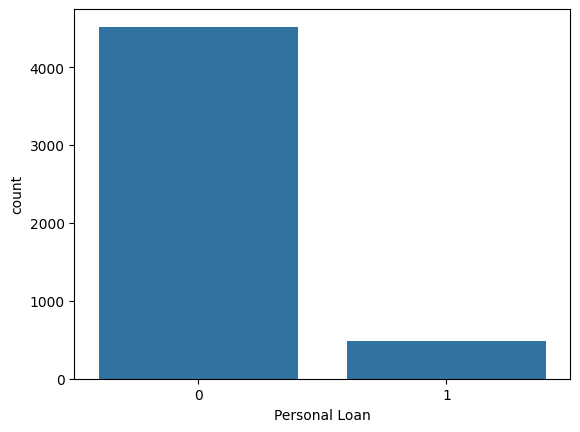

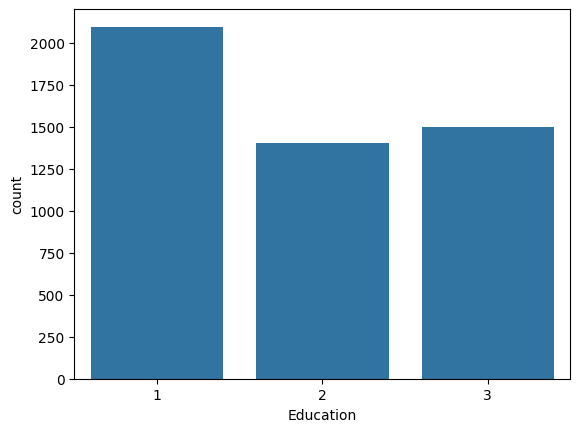

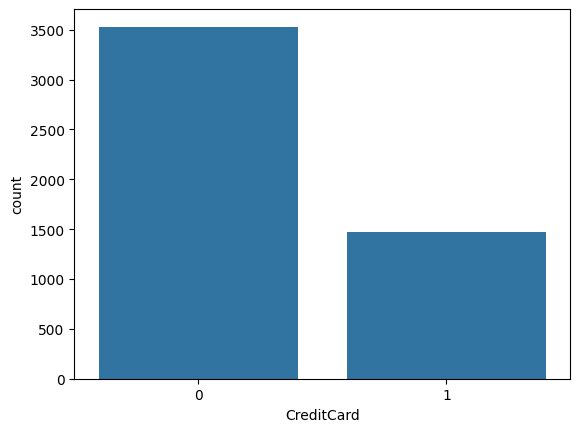

In [55]:
# Visualizations
sns.countplot(x="Personal Loan", data=df)
plt.show()

sns.countplot(x="Education", data=df)
plt.show()

sns.countplot(x="CreditCard", data=df)
plt.show()


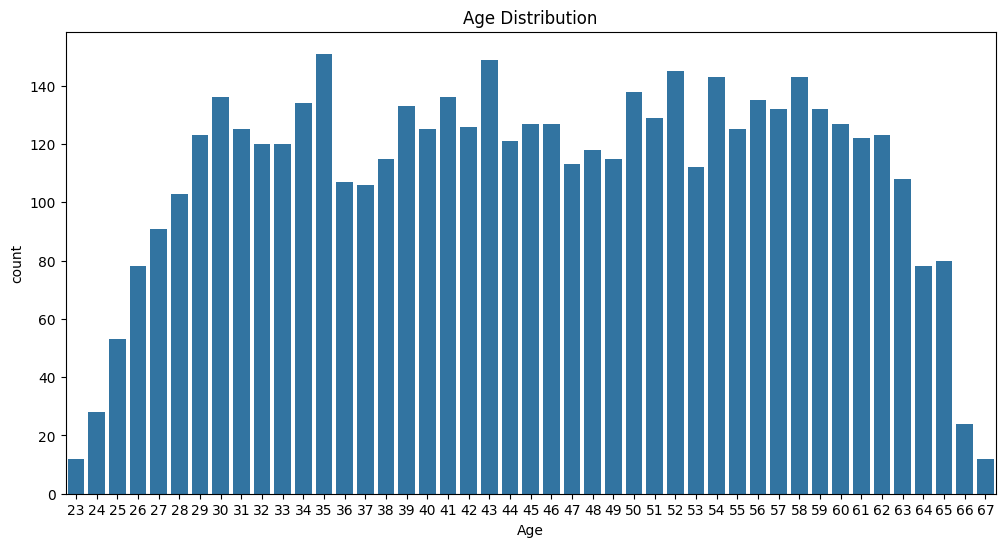

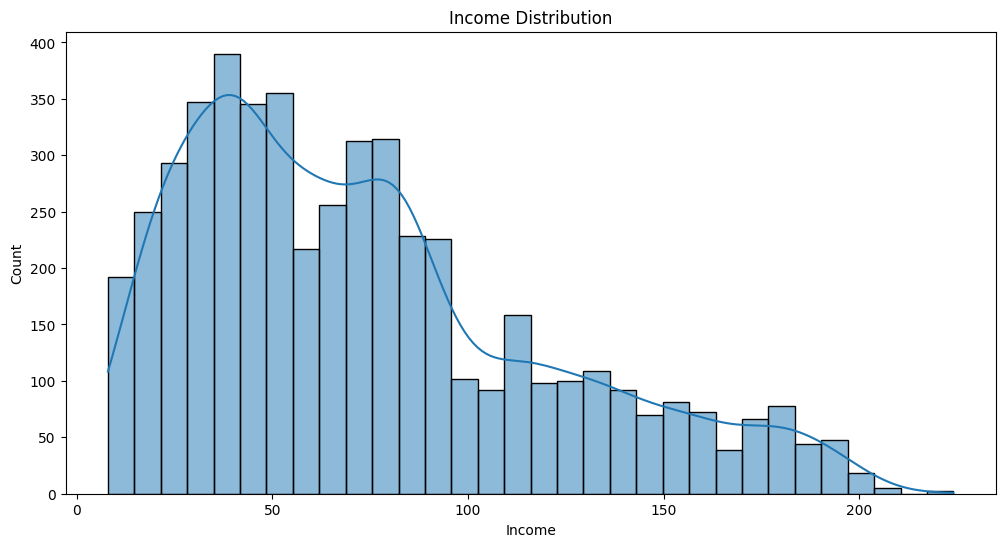

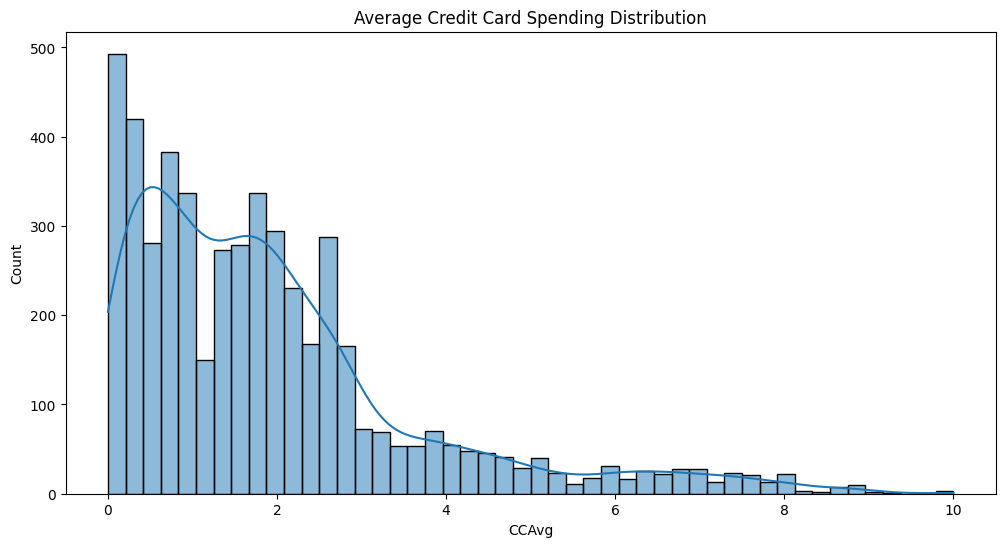

In [56]:
plt.figure(figsize=(12, 6))
sns.countplot(x="Age", data=df)
plt.title("Age Distribution")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df["Income"], kde=True)
plt.title("Income Distribution")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df["CCAvg"], kde=True)
plt.title("Average Credit Card Spending Distribution")
plt.show()


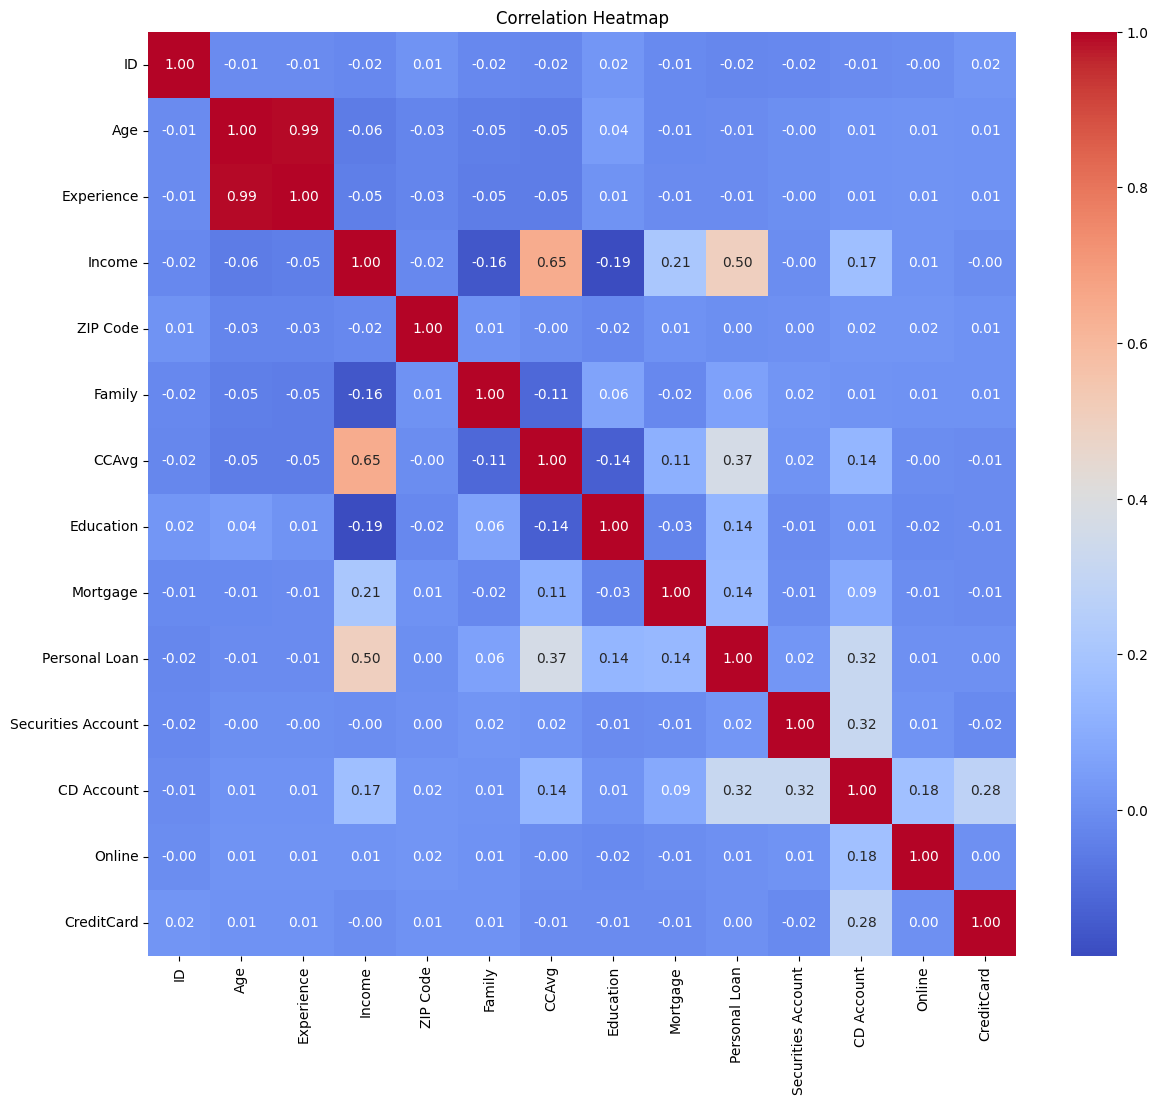

In [57]:
# Correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [58]:
# Drop irrelevant features
df = df.drop(columns=["ID", "ZIP Code"])

In [59]:
# Feature matrix and target
X = df.drop(columns=["Personal Loan"])
y = to_categorical(df["Personal Loan"])

In [60]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [61]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [62]:
# Define custom metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1_m(y_true, y_pred):
    prec = precision_m(y_true, y_pred)
    rec = recall_m(y_true, y_pred)
    return 2 * ((prec * rec) / (prec + rec + K.epsilon()))

In [63]:
# Build the ANN model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))  # Output layer for binary classification

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [64]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])

In [65]:
# Set early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [74]:
# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, callbacks=[early_stop], verbose=1)

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_m: 0.9867 - loss: 0.0457 - val_f1_m: 0.9774 - val_loss: 0.0688
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - f1_m: 0.9847 - loss: 0.0451 - val_f1_m: 0.9774 - val_loss: 0.0591
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - f1_m: 0.9836 - loss: 0.0445 - val_f1_m: 0.9817 - val_loss: 0.0556
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - f1_m: 0.9878 - loss: 0.0342 - val_f1_m: 0.9774 - val_loss: 0.0611
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_m: 0.9897 - loss: 0.0328 - val_f1_m: 0.9774 - val_loss: 0.0679
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - f1_m: 0.9835 - loss: 0.0436 - val_f1_m: 0.9731 - val_loss: 0.0705


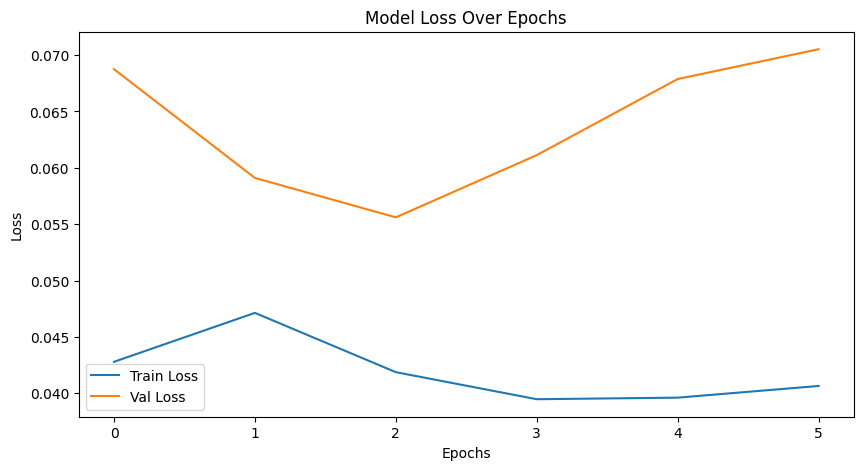

In [75]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [76]:
# Make predictions
pred_prob = model.predict(X_test)
y_pred = np.argmax(pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [77]:
# Evaluate model performance
print(f"Accuracy: {metrics.accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {metrics.precision_score(y_true, y_pred):.4f}")
print(f"Recall: {metrics.recall_score(y_true, y_pred):.4f}")
print(f"F1 Score: {metrics.f1_score(y_true, y_pred):.4f}")
print("\nClassification Report:")
print(metrics.classification_report(y_true, y_pred))

Accuracy: 0.9840
Precision: 0.9423
Recall: 0.9074
F1 Score: 0.9245

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       446
           1       0.94      0.91      0.92        54

    accuracy                           0.98       500
   macro avg       0.97      0.95      0.96       500
weighted avg       0.98      0.98      0.98       500



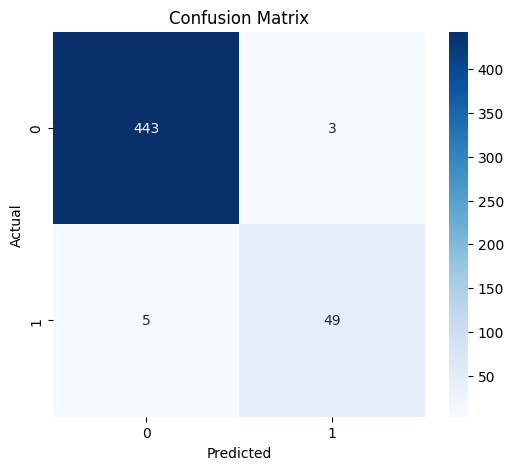

In [78]:
# Plot confusion matrix
conf_matrix = metrics.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [79]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("First 5 y_train rows:\n", y_train[:5])


X_train shape: (4500, 11)
y_train shape: (4500, 2)
First 5 y_train rows:
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [80]:
from sklearn.metrics import roc_auc_score, roc_curve
y_prob = pred_prob[:, 1]
auc = roc_auc_score(y_true, y_prob)
print("ROC-AUC Score:", auc)


ROC-AUC Score: 0.9949343962796877


In [81]:
model.save("bank_loan_model.h5")


In [84]:
import joblib

# After this line:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [85]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib

# Load model and scaler
model = load_model("bank_loan_model.h5", compile=False)
scaler = joblib.load('scaler.pkl')

# Define the input feature names (must match training order)
features = [
    "Age", "Experience", "Income", "Family", "CCAvg",
    "Education", "Mortgage", "Securities Account",
    "CD Account", "Online", "CreditCard"
]

print("\n--- Personal Loan Eligibility Prediction CLI ---\n")

# Collect user input
user_data = []
for feat in features:
    val = float(input(f"Enter value for {feat}: "))
    user_data.append(val)

# Prepare and scale input
user_array = np.array(user_data).reshape(1, -1)
user_scaled = scaler.transform(user_array)

# Predict
pred = model.predict(user_scaled)
pred_class = np.argmax(pred, axis=1)[0]
confidence = pred[0][pred_class]

# Output result
if pred_class == 1:
    print(f"\n✅ The customer is LIKELY to take a personal loan (Confidence: {confidence:.2%})")
else:
    print(f"\n❌ The customer is UNLIKELY to take a personal loan (Confidence: {confidence:.2%})")



--- Personal Loan Eligibility Prediction CLI ---

Enter value for Age: 21
Enter value for Experience: 2
Enter value for Income: 400000
Enter value for Family: 4
Enter value for CCAvg: 0
Enter value for Education: 2
Enter value for Mortgage: 0
Enter value for Securities Account: 0
Enter value for CD Account: 0
Enter value for Online: 1
Enter value for CreditCard: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step

✅ The customer is LIKELY to take a personal loan (Confidence: 100.00%)


In [89]:
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load trained model and scaler
model = load_model("bank_loan_model.h5")
scaler = joblib.load("scaler.pkl")

# Define input features (must be in same order as training)
features = [
    "Age",
    "Experience",
    "Income",
    "Family",
    "CCAvg",
    "Education (1=Bachelor, 2=Master, 3=Advanced)",
    "Mortgage",
    "Securities Account (0=No, 1=Yes)",
    "CD Account (0=No, 1=Yes)",
    "Online (0=No, 1=Yes)",
    "Credit Card (0=No, 1=Yes)"
]

print("\n📋 Bank Loan Approval Prediction CLI")
print("Please enter the following customer details:\n")

# Collect input from user
input_data = []
for feature in features:
    while True:
        try:
            val = float(input(f"{feature}: "))
            input_data.append(val)
            break
        except ValueError:
            print("❗ Invalid input. Please enter a numeric value.")

# Convert input to 2D array and scale
input_array = np.array(input_data).reshape(1, -1)
input_scaled = scaler.transform(input_array)

# Make prediction
prediction = model.predict(input_scaled)
predicted_class = int(np.argmax(prediction))
confidence = prediction[0][predicted_class]

# Output result
print("\n📊 Prediction Result:")
if predicted_class == 1:
    print(f"✅ Loan is likely to be APPROVED (Confidence: {confidence:.2%})")
else:
    print(f"❌ Loan is likely to be REJECTED (Confidence: {confidence:.2%})")



📋 Bank Loan Approval Prediction CLI
Please enter the following customer details:

Age: 25
Experience: 1
Income: 49
Family: 4
CCAvg: 1.60
Education (1=Bachelor, 2=Master, 3=Advanced): 1
Mortgage: 0
Securities Account (0=No, 1=Yes): 1
CD Account (0=No, 1=Yes): 0
Online (0=No, 1=Yes): 0
Credit Card (0=No, 1=Yes): 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step

📊 Prediction Result:
✅ Loan is likely to be APPROVED (Confidence: 100.00%)
